# First look at data 

#### Emilie Jessen - Date: 07-02-2022

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         
from os.path import dirname as parent_folde
import pandas as pd

In [4]:
sys.path.append('../AppStat/AppStat2021/External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

sys.path.append('../AppStat/AppStat2021/Emilie_External_Functions')
from EmilieExternalFunctions import zerobin_hist, chi2_test, get_chi2_values

sys.path.append('BachelorExternalFunctions')
from Bachelor_ExternalFunctions import peak_plotter, peak_finder, compare_peaks
from Bachelor_ExternalFunctions import amp_plotter, amplitudes

In [5]:
# Set som plotting standards:

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)


save_plots = False

In [6]:
# Getting the data and converting to numpy array: 

dataframe_m = pd.read_csv('Data/mdata.csv', header=None, index_col=None)
dataframe_p = pd.read_csv('Data/pdata.csv', header=None, index_col=None)

dataframe_m = dataframe_m.to_numpy()
dataframe_p = dataframe_p.to_numpy()

In [7]:
# Identifying and saving the traces, where the concentration gets very small. 

removed_traces_m = []
removed_idx = [] 
removed_traces_p = []

for i in range(0, 422): 
    for j in range(49, 287):  # Ocsillation should begin after the 49th datapoint. 
        if dataframe_m[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            
        if dataframe_p[i][j] < 0.1: 
            removed_traces_m.append(dataframe_m[i])
            removed_traces_p.append(dataframe_p[i])
            removed_idx.append(i)
            break

In [8]:
# Cleaning the dataframes for traces:  

data_m = np.delete(dataframe_m, removed_idx, 0)
data_p = np.delete(dataframe_p, removed_idx, 0)

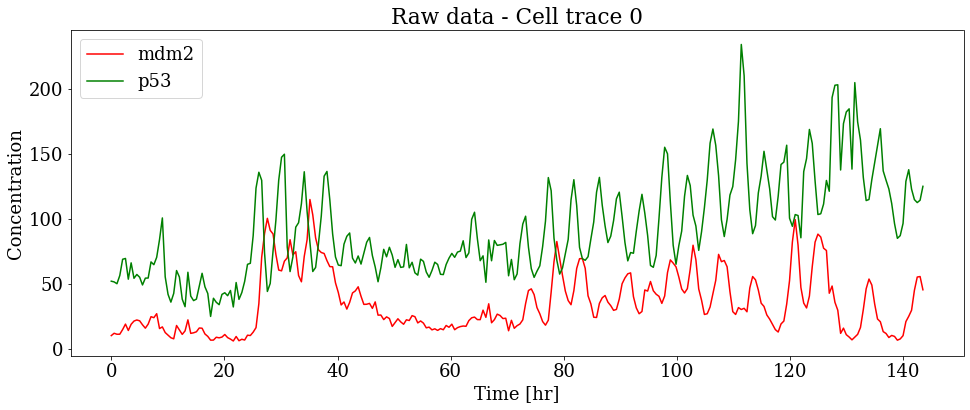

In [9]:
# Plotting an example of a trace: 

time = np.linspace(0, 287/2, 287)

fig, ax = plt.subplots(figsize=(16,6))

ax.plot(time, dataframe_m[0], color='r', label='mdm2')
#ax.plot(time, dataframe_m[0], 'x', color='k', label='mdm2')
ax.plot(time, dataframe_p[0], color='g', label='p53')

ax.set(xlabel='Time [hr]',
       ylabel='Concentration', 
       title='Raw data - Cell trace 0')

ax.legend(loc='upper left')

if save_plots: 
    fig.savefig(r'Graphs/RawData.png');

In [10]:
# Averaging cell traces

ave_trace_m = [np.mean(data_m[:,i]) for i in range(len(data_m[0]))]
ave_trace_p = [np.mean(data_p[:,i]) for i in range(len(data_p[0]))]

std_m = np.array([np.std(data_m[:,i]) for i in range(len(data_m[0]))]) #/ np.sqrt(len(data_m))
std_p = np.array([np.std(data_p[:,i]) for i in range(len(data_p[0]))]) #/ np.sqrt(len(data_p))

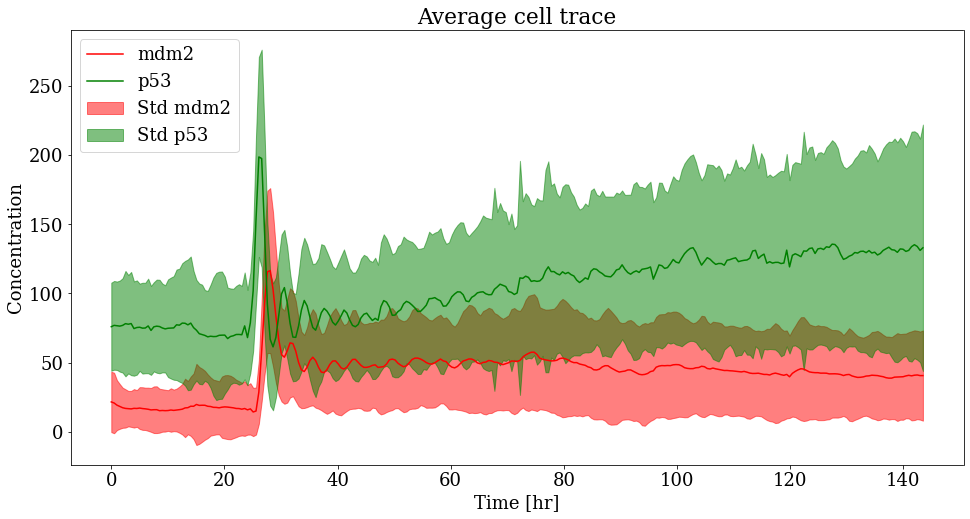

In [11]:
# Plotting the average cell trace: 

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(time, ave_trace_m, color='r', label='mdm2')
ax.plot(time, ave_trace_p, color='g', label='p53')

plt.fill_between(time, ave_trace_m - std_m, ave_trace_m + std_m, color='r', alpha=0.5, label='Std mdm2')
plt.fill_between(time, ave_trace_p - std_p, ave_trace_p + std_p, color='g', alpha=0.5, label='Std p53')


ax.set(xlabel='Time [hr]',
       ylabel='Concentration', 
       title='Average cell trace')

ax.legend(loc='upper left')

if save_plots: 
    fig.savefig(r'Graphs/AverageTrace.png');

In [12]:
# Finding the average fluctuations before oscillations to use as a baseline/initial error for fitting

fluct_m = [(np.std(data_m[i][:49], ddof=1)) for i in range(len(data_m))]  
fluct_p = [(np.std(data_p[i][:49], ddof=1)) for i in range(len(data_p))]

avefluct_m = np.mean(fluct_m)  # Maybe use mode/median instead
avefluct_p = np.mean(fluct_p)

print(f'The mean fluctuations before oscillations: {avefluct_m:.2f}(mdm2) and {avefluct_p:.2f}(p53)')

The mean fluctuations before oscillations: 9.34(mdm2) and 22.37(p53)


In [13]:
# Removing noise by fitting a fourth order polynomium: 
# Example for the first data series: 

def remove_noise4(x, p0, p1, p2, p3, p4): 
    return p0 + p1*x + p2*x**2 + p3*x**3 + p4*x**4

t = time[49:]


fit_obj_m0 = Chi2Regression(remove_noise4, t, data_m[0][49:], avefluct_m)
fit_obj_p0 = Chi2Regression(remove_noise4, t, data_p[0][49:], avefluct_p)

minuit_m0 = Minuit(fit_obj_m0, 30, 1, 1, 1, 1)
minuit_p0 = Minuit(fit_obj_p0, 30, 1, 1, 1, 1)

minuit_m0.errordef = 1.0  
minuit_p0.errordef = 1.0 

minuit_m0.migrad() 
minuit_p0.migrad();

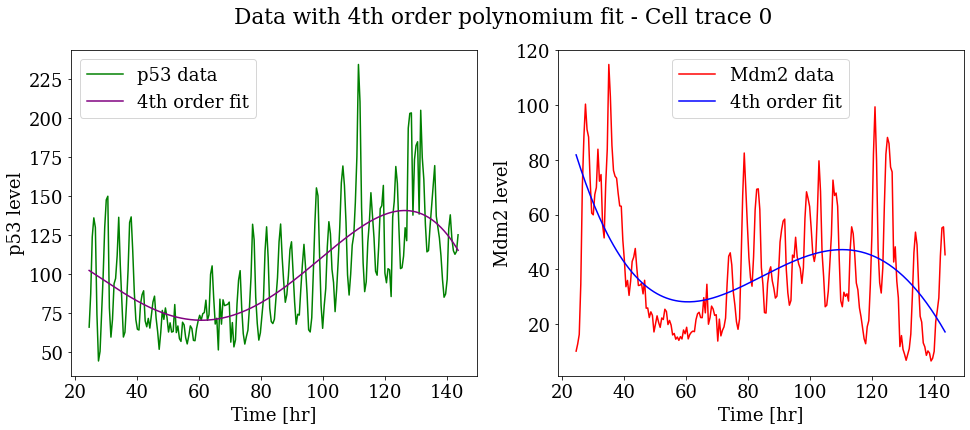

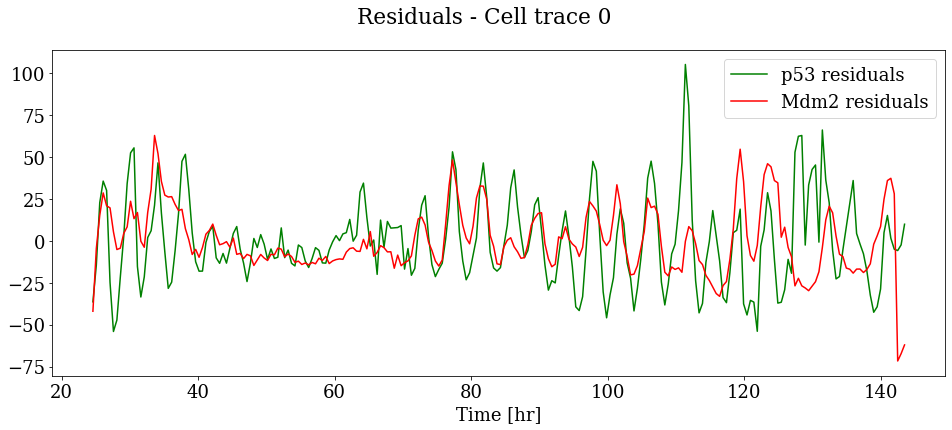

In [22]:
# Plotting the results for the example data series: 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle('Data with 4th order polynomium fit - Cell trace 0')

ax1.plot(t, data_p[0][49:], color='green', label='p53 data')
ax1.plot(t, remove_noise4(time[49:], *minuit_p0.values[:]), color='purple', label='4th order fit')
ax1.set(xlabel='Time [hr]', 
        ylabel='p53 level')
ax1.legend()

ax2.plot(t, data_m[0][49:], color='red', label='Mdm2 data')
ax2.plot(t, remove_noise4(time[49:], *minuit_m0.values[:]), color='blue', label='4th order fit')
ax2.set(xlabel='Time [hr]', 
        ylabel='Mdm2 level')
ax2.legend()

if save_plots: 
    fig.savefig(r'Graphs/NoiseFit.png');


# Calculating the residuals and plotting: 

resi_m0 = data_m[0][49:] - remove_noise4(t, *minuit_m0.values[:])
resi_m0_roll = np.roll(resi_m0, -3)
resi_p0 = data_p[0][49:] - remove_noise4(t, *minuit_p0.values[:])



fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle('Residuals - Cell trace 0')
ax.plot(t, resi_p0, color='green', label='p53 residuals')
ax.plot(t, resi_m0_roll, color='red', label='Mdm2 residuals')
ax.set(xlabel='Time [hr]')
ax.legend()

if save_plots: 
    fig.savefig(r'Graphs/Residuals.png');

In [24]:
# Calculation the residuals for all of the data series: 

resi_m = []
resi_p = []

for i in range(len(data_m)): 
    
    fit_obj_m = Chi2Regression(remove_noise4, t, data_m[i][49:], avefluct_m)
    fit_obj_p = Chi2Regression(remove_noise4, t, data_p[i][49:], avefluct_p)

    minuit_m = Minuit(fit_obj_m, 30, 1, 1, 1, 1)
    minuit_p = Minuit(fit_obj_p, 30, 1, 1, 1, 1)
    
    minuit_m.errordef = 1.0  
    minuit_p.errordef = 1.0 

    minuit_m.migrad() 
    minuit_p.migrad()
    
    resi_m.append(data_m[i][49:] - remove_noise4(t, *minuit_m.values[:]))
    resi_p.append(data_p[i][49:] - remove_noise4(t, *minuit_p.values[:]))

In [25]:
print(f'The mean of the p53 and Mdm2 residuals: {np.mean(resi_p):.5f} and {np.mean(resi_m):.6f}')

The mean of the p53 and Mdm2 residuals: -0.00015 and -0.000031


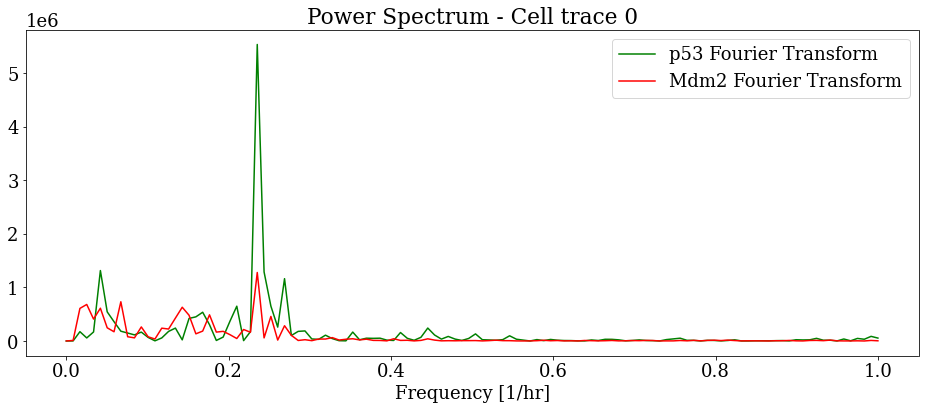

In [26]:
# Power spectrum to determine frequency

from scipy.fft import rfft, ifft, fftfreq

sampling_rate = 2  # 2 datapoints per hour  

FT_m0 = np.abs(rfft(resi_m0))**2
FT_p0 = np.abs(rfft(resi_p0))**2

frequency = np.linspace(0, sampling_rate/2, len(FT_m0))

fig, ax = plt.subplots(figsize=(16,6))

ax.plot(frequency, FT_p0, color='green', label='p53 Fourier Transform')
ax.plot(frequency, FT_m0, color='red', label='Mdm2 Fourier Transform')
ax.set(xlabel='Frequency [1/hr]', 
       title='Power Spectrum - Cell trace 0')
ax.legend()

if save_plots: 
    fig.savefig(r'Graphs/PowerSpectrum.png');

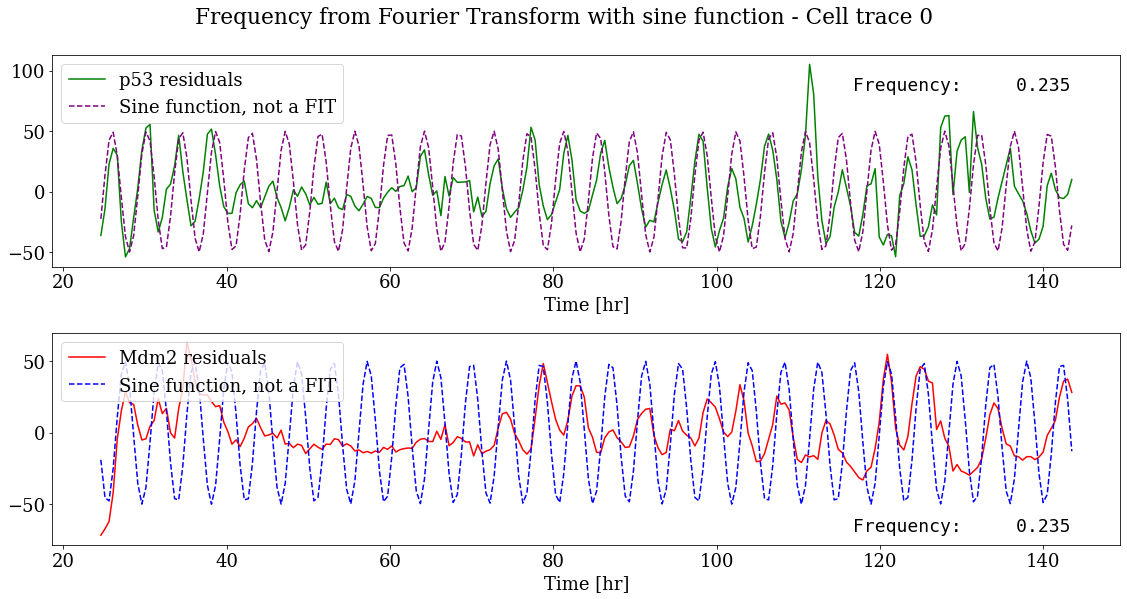

In [27]:
# Plotting a sine function on top to qualitatively find out if the frequency fits: 

max_freq_p0 = frequency[np.argmax(FT_p0)]
max_freq_m0 = frequency[np.argmax(FT_m0)]


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,8))
fig.suptitle('Frequency from Fourier Transform with sine function - Cell trace 0', y=1.05)

ax1.plot(t, resi_p0, color='green', label='p53 residuals')
ax1.plot(t, 50*np.sin(2*np.pi*max_freq_p0*t - 5.4), linestyle='dashed', color='purple', label='Sine function, not a FIT')

ax1.set(xlabel='Time [hr]')
ax1.legend(loc='upper left')

add_text_to_ax(0.75, 0.9, nice_string_output({'Frequency:': max_freq_p0}), ax1, fontsize=18)

ax2.plot(t, resi_m0, color='red', label='Mdm2 residuals')
ax2.plot(t, 50*np.sin(2*np.pi*max_freq_m0*t - 1.4), linestyle='dashed', color='blue', label='Sine function, not a FIT')

ax2.set(xlabel='Time [hr]')
ax2.legend(loc='upper left')

add_text_to_ax(0.75, 0.13, nice_string_output({'Frequency:': max_freq_m0}), ax2, fontsize=18)

fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/FreqCheck.png');

In [28]:
# Finding the frequency for all cells: 

max_freqs_m = []
max_freqs_p = []

FT_m = []
FT_p = []

FT_m_norm = []
FT_p_norm = []

for i in range(len(data_m)): 
    FTm = np.abs(rfft(resi_m[i]))**2
    FTp = np.abs(rfft(resi_p[i]))**2
    
    FT_m.append(FTm)
    FT_p.append(FTp)
    
    FT_m_norm.append(FTm / max(FTm))
    FT_p_norm.append(FTp / max(FTp))
    
    max_freqs_m.append(frequency[np.argmax(FTm)])
    max_freqs_p.append(frequency[np.argmax(FTp)])

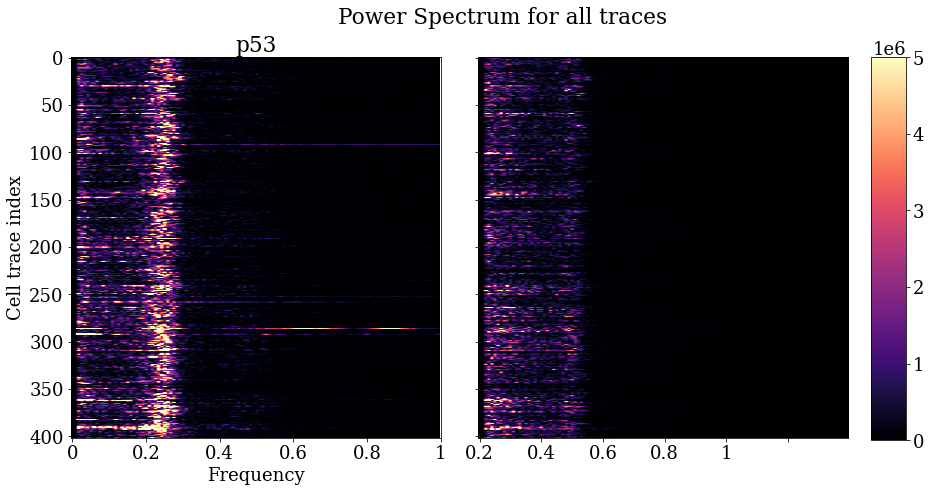

In [29]:
# Plotting the power spectrums as a matrix: 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)
suptitle = fig.suptitle('Power Spectrum for all traces', y=0.98)

xticks_pos = np.linspace(0, 120, 6)
xticks_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

im1 = axs[0].imshow(FT_p, cmap='magma', aspect='auto', vmin=0, vmax=5*10**6)
axs[0].set(xticks=xticks_pos, 
        xlabel='Frequency',
        ylabel='Cell trace index',
        title='p53')

axs[0].set_xticklabels(xticks_labels)

im2 = axs[1].imshow(FT_m, cmap='magma', aspect='auto', vmin=0, vmax=5*10**6)
ax2.set(xticks=xticks_pos, 
        xlabel='Frequency', 
        title='mdm2')
axs[1].set_xticklabels(xticks_labels)

fig.subplots_adjust(right=0.8, wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.76])   # left, bottom, width, height
fig.colorbar(im1, cax=cbar_ax)

#fig.tight_layout()


if save_plots: 
    plt.savefig(r'Graphs/PowerSpecMatrix.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

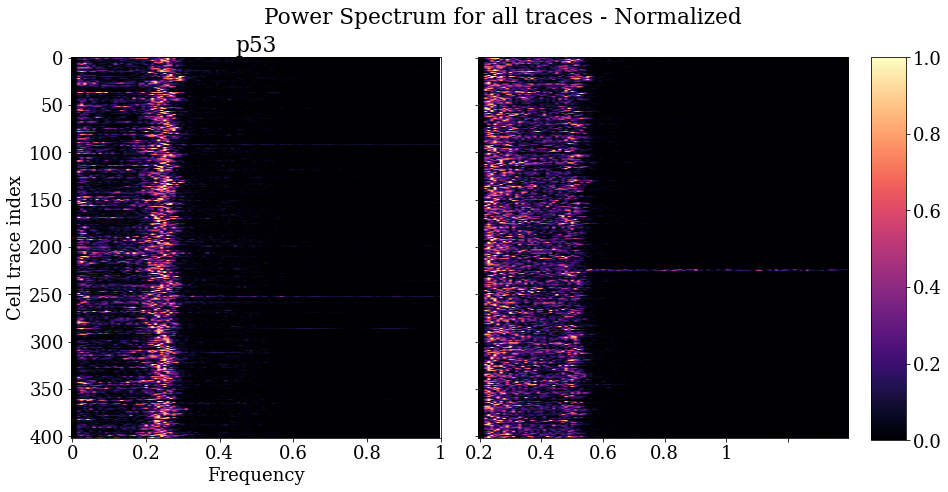

In [30]:
# Plotting the normalized power spectrums as a matrix: 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharey=True)
suptitle = fig.suptitle('Power Spectrum for all traces - Normalized', y=0.98)

xticks_pos = np.linspace(0, 120, 6)
xticks_labels = ['0', '0.2', '0.4', '0.6', '0.8', '1']

im1 = axs[0].imshow(FT_p_norm, cmap='magma', aspect='auto', vmin=0, vmax=1)
axs[0].set(xticks=xticks_pos, 
        xlabel='Frequency',
        ylabel='Cell trace index',
        title='p53')

axs[0].set_xticklabels(xticks_labels)

im2 = axs[1].imshow(FT_m_norm, cmap='magma', aspect='auto', vmin=0, vmax=1)
ax2.set(xticks=xticks_pos, 
        xlabel='Frequency', 
        title='mdm2')
axs[1].set_xticklabels(xticks_labels)

fig.subplots_adjust(right=0.8, wspace=0.1)
cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.76])   # left, bottom, width, height
fig.colorbar(im1, cax=cbar_ax)

#fig.tight_layout()


if save_plots: 
    plt.savefig(r'Graphs/PowerSpecMatrixNorm.png', bbox_inches='tight', bbox_extra_artists=[suptitle]);

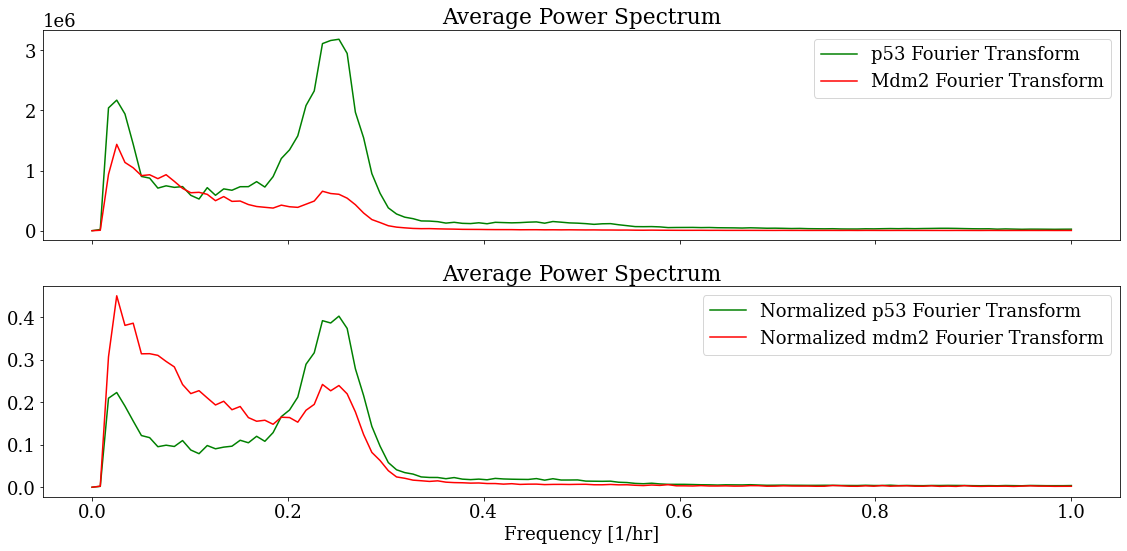

In [31]:
# Finding mean along the columns and plotting the average power spectrum : 

FT_p_mean = np.mean(FT_p, axis=0)
FT_m_mean = np.mean(FT_m, axis=0)

FT_p_norm_mean = np.mean(FT_p_norm, axis=0)
FT_m_norm_mean = np.mean(FT_m_norm, axis=0)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True)

ax1.plot(frequency, FT_p_mean, color='green', label='p53 Fourier Transform')
ax1.plot(frequency, FT_m_mean, color='red', label='Mdm2 Fourier Transform')
ax1.set(title='Average Power Spectrum')
ax1.legend()

ax2.plot(frequency, FT_p_norm_mean, color='green', label='Normalized p53 Fourier Transform')
ax2.plot(frequency, FT_m_norm_mean, color='red', label='Normalized mdm2 Fourier Transform')
ax2.set(xlabel='Frequency [1/hr]', 
       title='Average Power Spectrum')

ax2.legend()

fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/AvePowerSpectrumDobble.png');

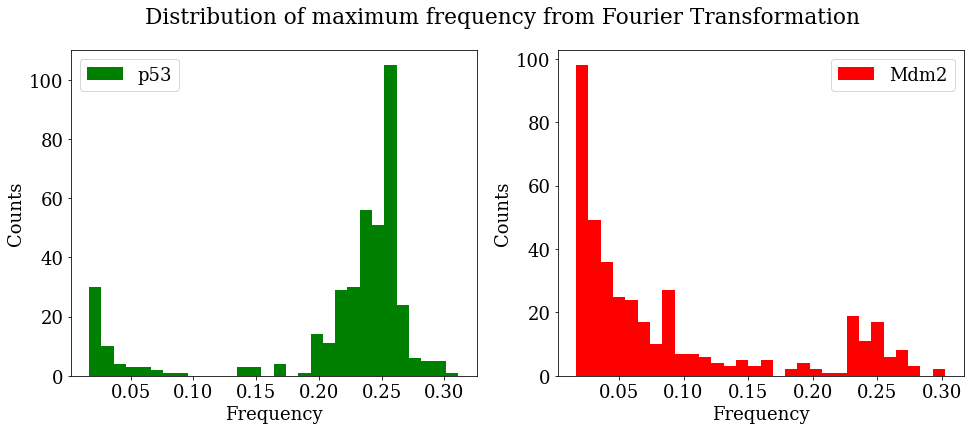

In [32]:
# The distribution of maximum frequencies from power spectrum: 
# Note: this does not look correct. Especially for mdm2...

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle('Distribution of maximum frequency from Fourier Transformation')

ax1.hist(max_freqs_p, 30, (min(max_freqs_p), max(max_freqs_p)), color='green', label='p53')
ax1.set(xlabel='Frequency', 
        ylabel='Counts', )
ax1.legend()

ax2.hist(max_freqs_m, 30, (min(max_freqs_m), max(max_freqs_m)), color='red', label='Mdm2')
ax2.set(xlabel='Frequency', 
        ylabel='Counts', )
ax2.legend()

if save_plots: 
    fig.savefig(r'Graphs/DistMaxFreq.png');

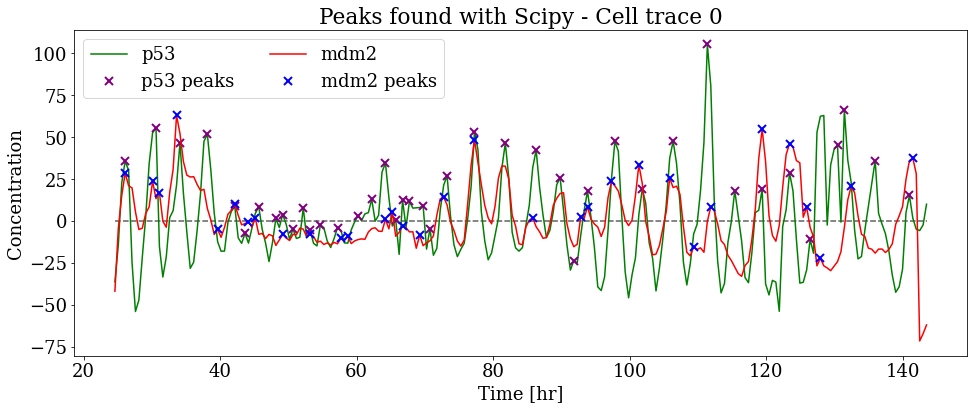

In [33]:
# Initial peak finding with Scipy: 

from scipy.signal import find_peaks

peaks_p0, _ = find_peaks(resi_p0, distance=2, height=(-25, None), threshold=(1, None))
peaks_m0, _ = find_peaks(resi_m0_roll, distance=2, height=(-25, None),threshold=(1, None))


fig, ax = plt.subplots(figsize=(16,6))

peak_plotter(t, resi_p0, peaks_p0, ax, name='p53')
peak_plotter(t, resi_m0_roll, peaks_m0, ax, 'mdm2')


ax.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='Peaks found with Scipy - Cell trace 0')
ax.legend(ncol=2);

In [34]:
# Trying to use the slope to specify peaks: 

def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)


slopes = []

for i in range(len(resi_p)):
    slopes.extend(np.diff(resi_p[i]))

Nbins = 200 
xmin, xmax = -300, 300
binwidth = (xmax - xmin) / Nbins 

def norm_gauss(x, N, mu, sigma):                       
    return N * binwidth * gauss_pdf(x, mu, sigma)


x, y, sy = zerobin_hist(slopes, Nbins, xmin, xmax, ax)

minuit = chi2_test(slopes, Nbins, xmin, xmax, norm_gauss, len(slopes), 10, 10)  
minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4170                       │              Nfcn = 86               │
│ EDM = 2.53e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  91.08e3  │  0.30e3   │            │            │         │         │       │
│ 1 │ mu    │   1.55    │   0.09    │            │            │         │         │       │
│ 2 │ sigma │   26.54   │   0.09    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        N       mu    sigma │
├───────┼────────────────────────────┤
│     N │ 9.09e+04   -0.122  -0.0717 │
│    mu │   -0.122  0.00816 -0.00201 │
│ sigma │  -0.0717 -0.00201  0.00811 │
└───────┴────────────────────────────┘

In [35]:
# Get the values from the fit: 
chi2_value, Ndof, p_value = get_chi2_values(minuit, Nbins)

Fit value: N = 91084.96703 +/- 301.48909
Fit value: mu = 1.54702 +/- 0.09036
Fit value: sigma = 26.54111 +/- 0.09008
Chi2 value: 4170.0   Ndof = 197    Prob(Chi2,Ndof) = 0.000


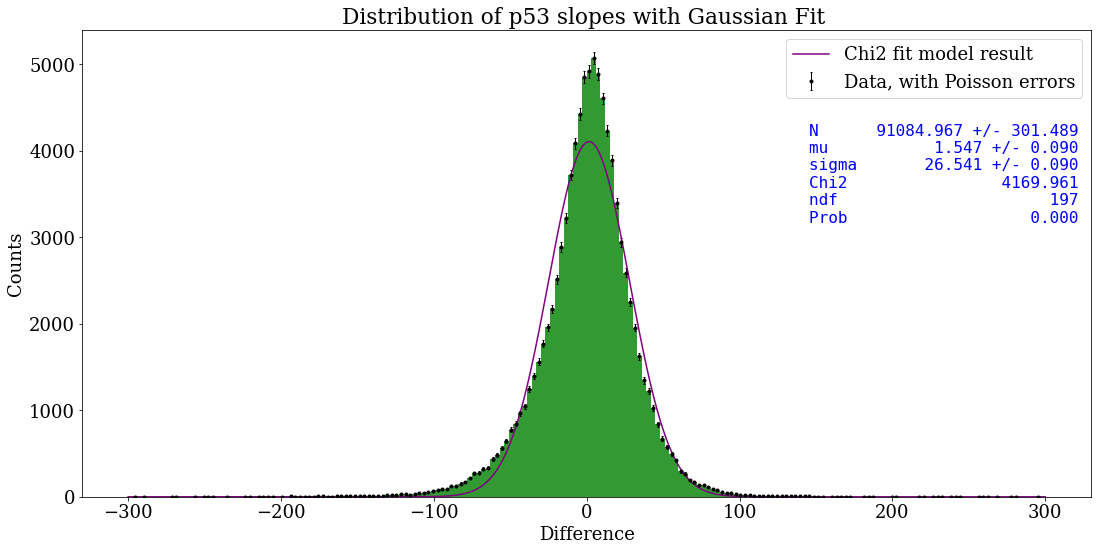

In [36]:
# Plot the data + fit for visualisation: 
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches

ax.hist(slopes, Nbins, range=(xmin, xmax), color='green', alpha=0.8)
ax.errorbar(x, y, yerr=sy, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax.set(xlabel = "Difference",
       ylabel = "Counts",  
       title = "Distribution of p53 slopes with Gaussian Fit ",)

xaxis = np.linspace(xmin, xmax, 1000)
ax.plot(xaxis, norm_gauss(xaxis, *minuit.values[:]), linestyle='-', color='purple', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'N':   [minuit.values['N'], minuit.errors['N']],
     'mu':       [minuit.values['mu'], minuit.errors['mu']],
     'sigma':       [minuit.values['sigma'], minuit.errors['sigma']],
     'Chi2':     chi2_value,
     'ndf':      Ndof,
     'Prob':     p_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.72, 0.8, text, ax, fontsize=16, color='b')
ax.legend(loc='upper right')
fig.tight_layout()

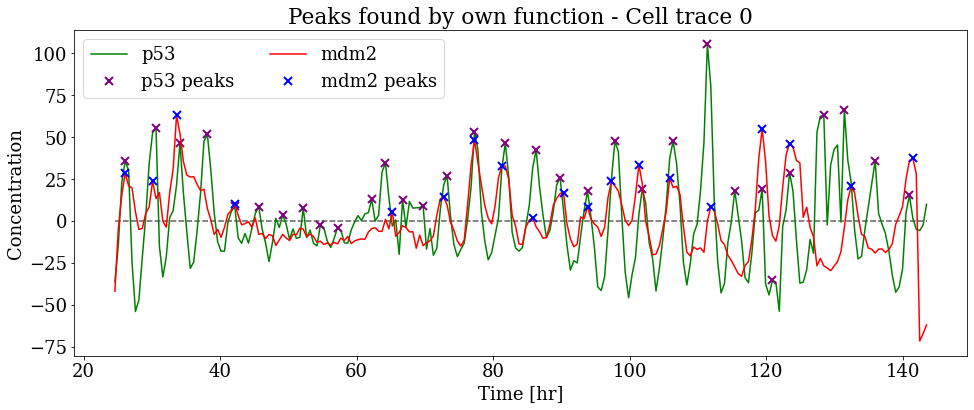

In [37]:
# Plotting to see if own peak finder works: 

own_peaks_p0, local_min_p0 = peak_finder(resi_p0, N_peaks='high', threshold=avefluct_m)
own_peaks_m0, local_min_m0 = peak_finder(resi_m0_roll, N_peaks='low', threshold=avefluct_m)


fig, ax = plt.subplots(figsize=(16,6))

peak_plotter(t, resi_p0, own_peaks_p0, ax, 'p53')
peak_plotter(t, resi_m0_roll, own_peaks_m0, ax, 'mdm2')


ax.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='Peaks found by own function - Cell trace 0')
ax.legend(ncol=2)

if save_plots: 
    fig.savefig(r'Graphs/AllPeaksOwn.png');

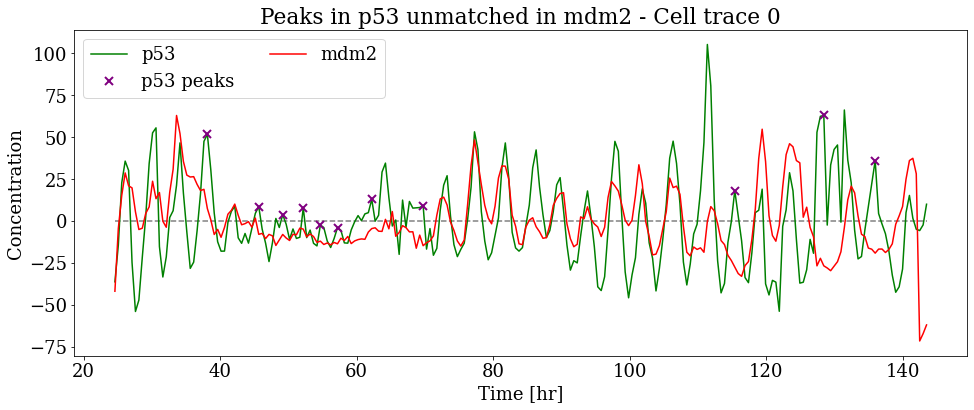

In [38]:
mdm2_slips0 = compare_peaks(own_peaks_p0, own_peaks_m0, local_min_p0)[1]

fig, ax = plt.subplots(figsize=(16,6))

peak_plotter(t, resi_p0, mdm2_slips0, ax, 'p53')
ax.plot(t, resi_m0_roll, color='red', label='mdm2')


ax.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='Peaks in p53 unmatched in mdm2 - Cell trace 0')
ax.legend(ncol=2)

if save_plots: 
    fig.savefig(r'Graphs/mdm2slips.png');

In [39]:
# Shifting all mdm2 traces three places: 

roll_resi_m = np.zeros(shape=(402, 238))

for i in range(len(resi_m)): 
    roll_resi_m[i] = np.roll(resi_m[i], -3)

p53 slips happens in 131 of the cell traces


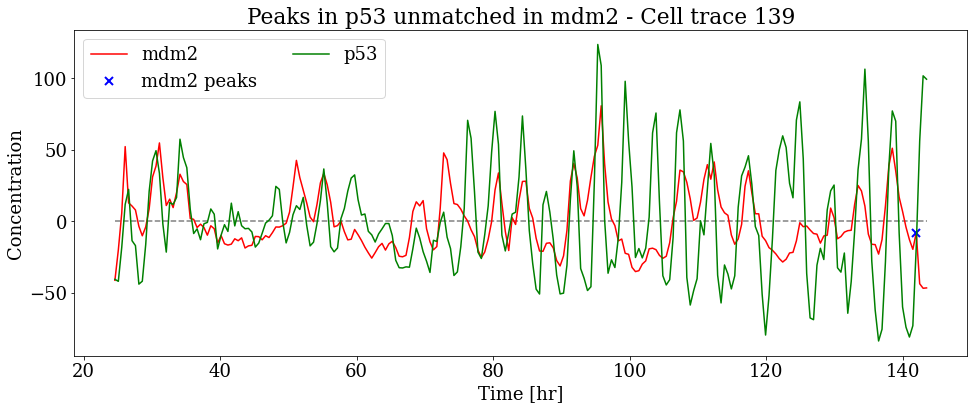

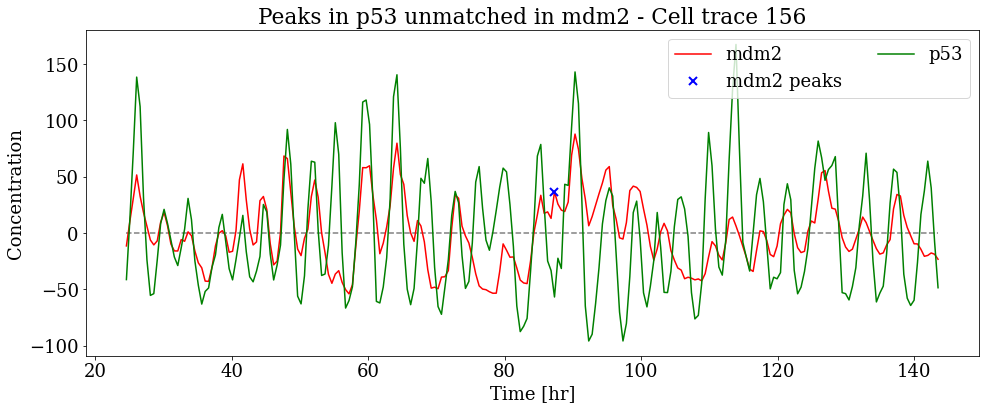

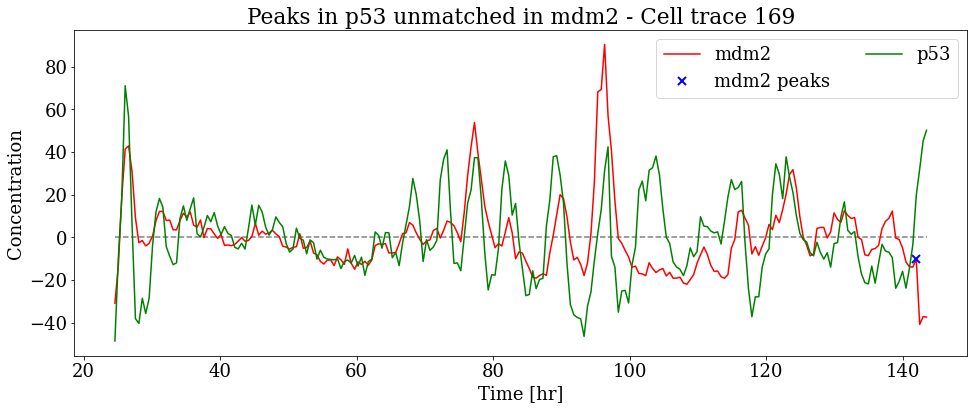

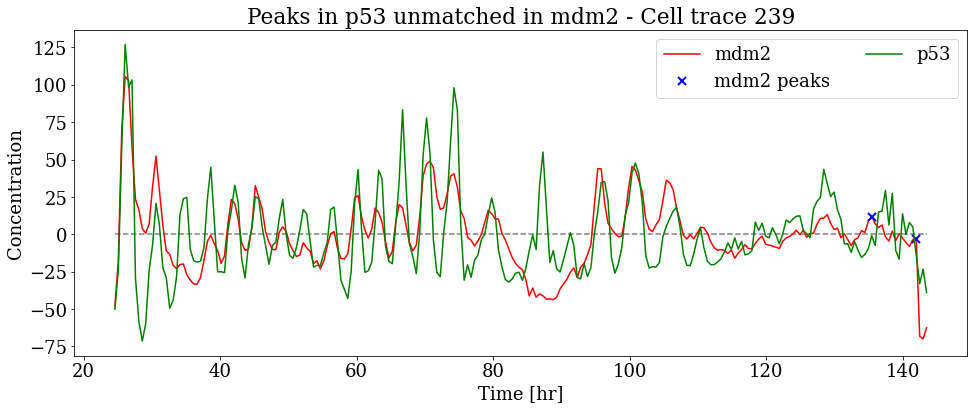

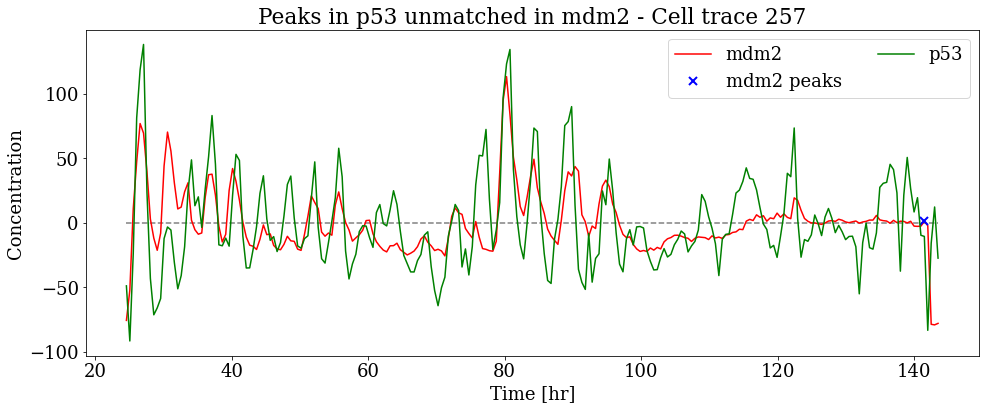

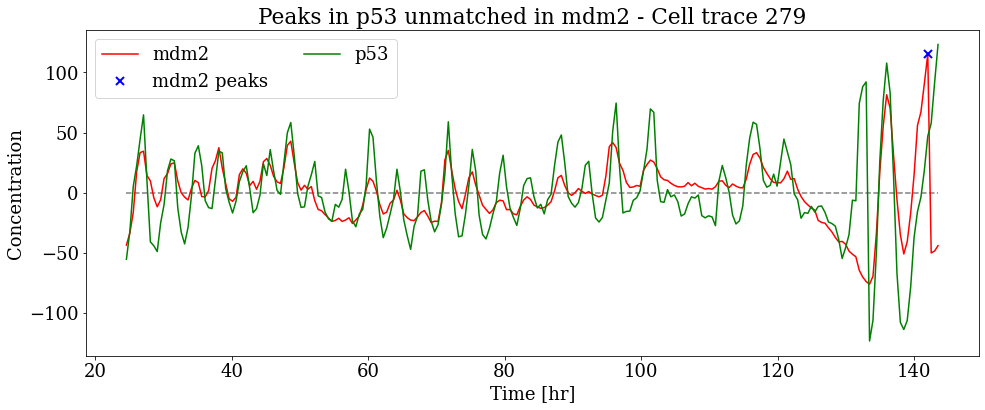

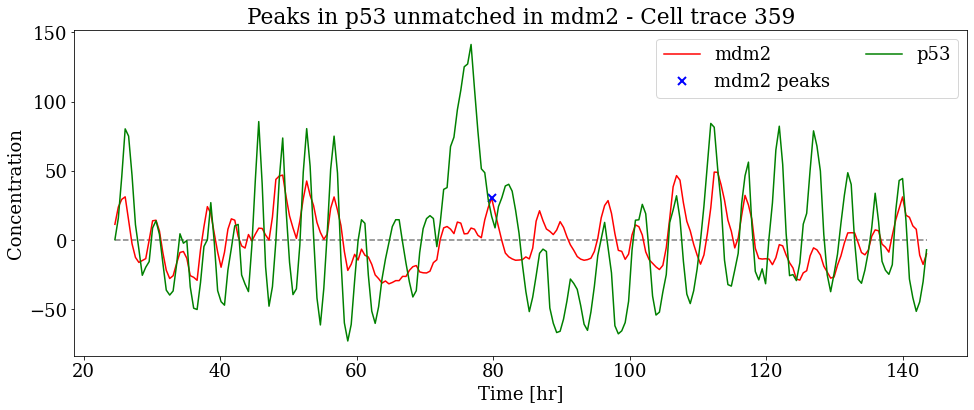

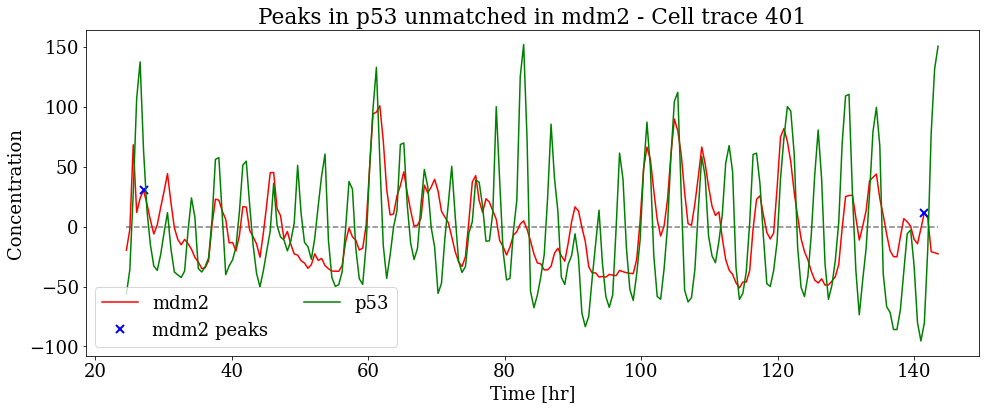

In [40]:
# Checking for slips in p53 - that is peaks in mdm2 not matched by p53

p53_slips = []

local_min_p = [] 

for i in range(len(resi_p)): 
    
    own_peaks_p, local_min = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)
    own_peaks_m = peak_finder(roll_resi_m[i], N_peaks='low', threshold=avefluct_m)[0]
    
    local_min_p.append(local_min)
    
    slips = compare_peaks(own_peaks_m, own_peaks_p, local_min)[1]
    
    if len(slips) > 0: 
        p53_slips.append(slips)
        
        if i % 20 == 0: 
            fig, ax = plt.subplots(figsize=(16,6))

            peak_plotter(t, roll_resi_m[i], slips, ax, 'mdm2')
            ax.plot(t, resi_p[i], color='green', label='p53')


        ax.set(xlabel='Time [hr]', 
               ylabel='Concentration', 
               title=f'Peaks in p53 unmatched in mdm2 - Cell trace {i}')
        ax.legend(ncol=2)

print(f'p53 slips happens in {len(p53_slips)} of the cell traces')

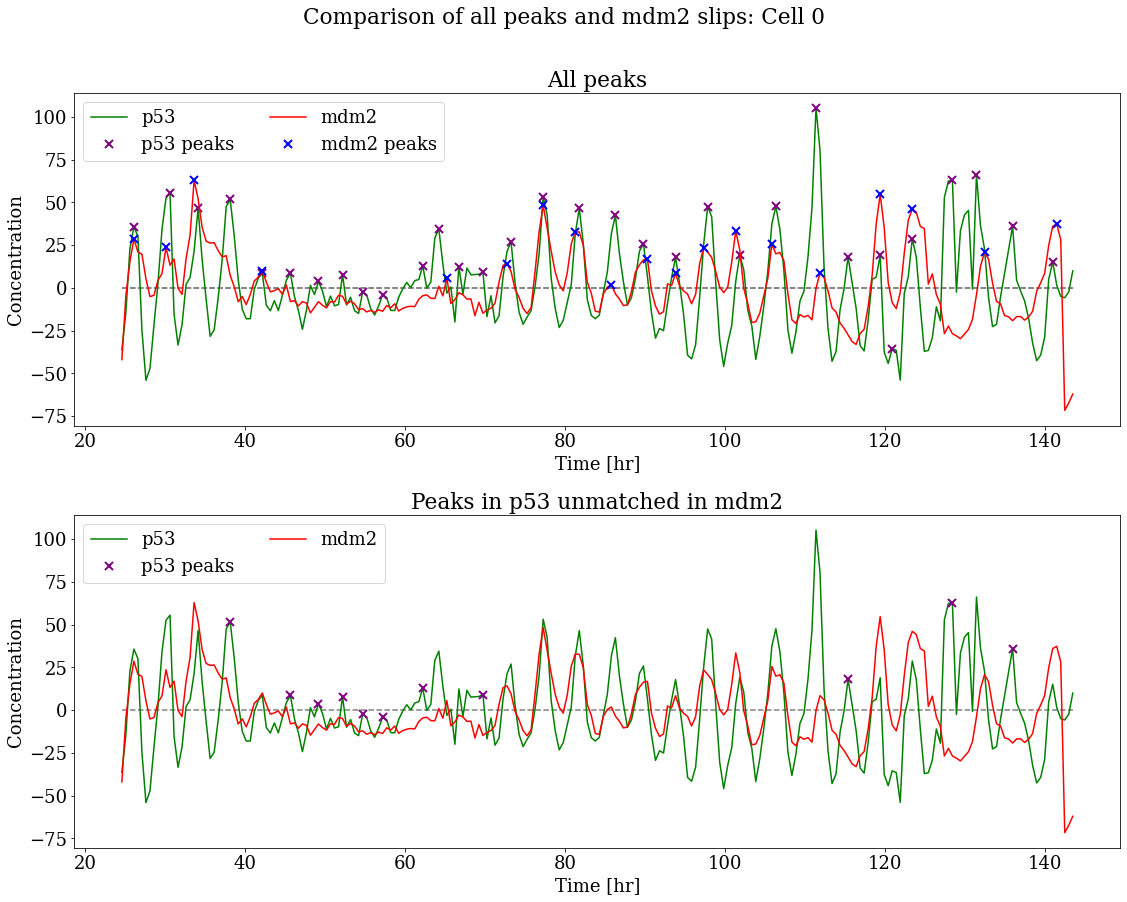

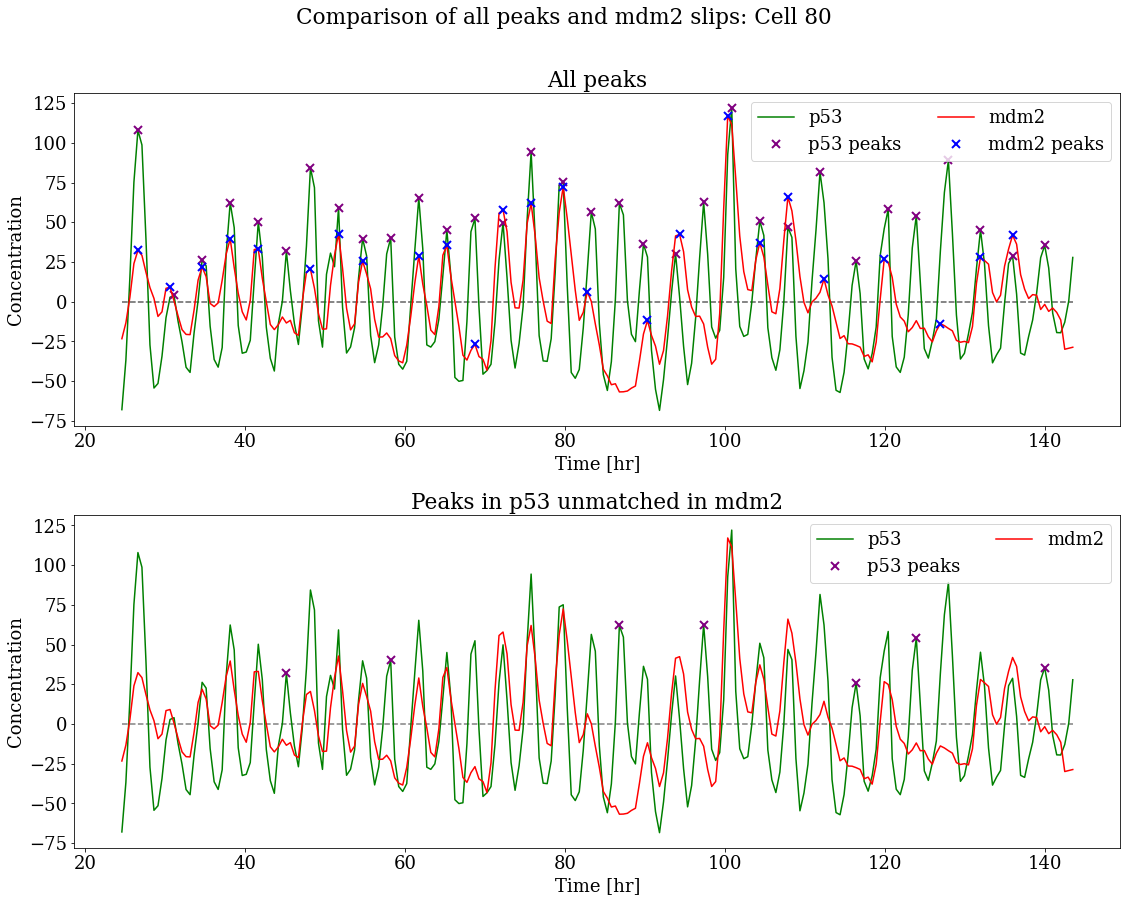

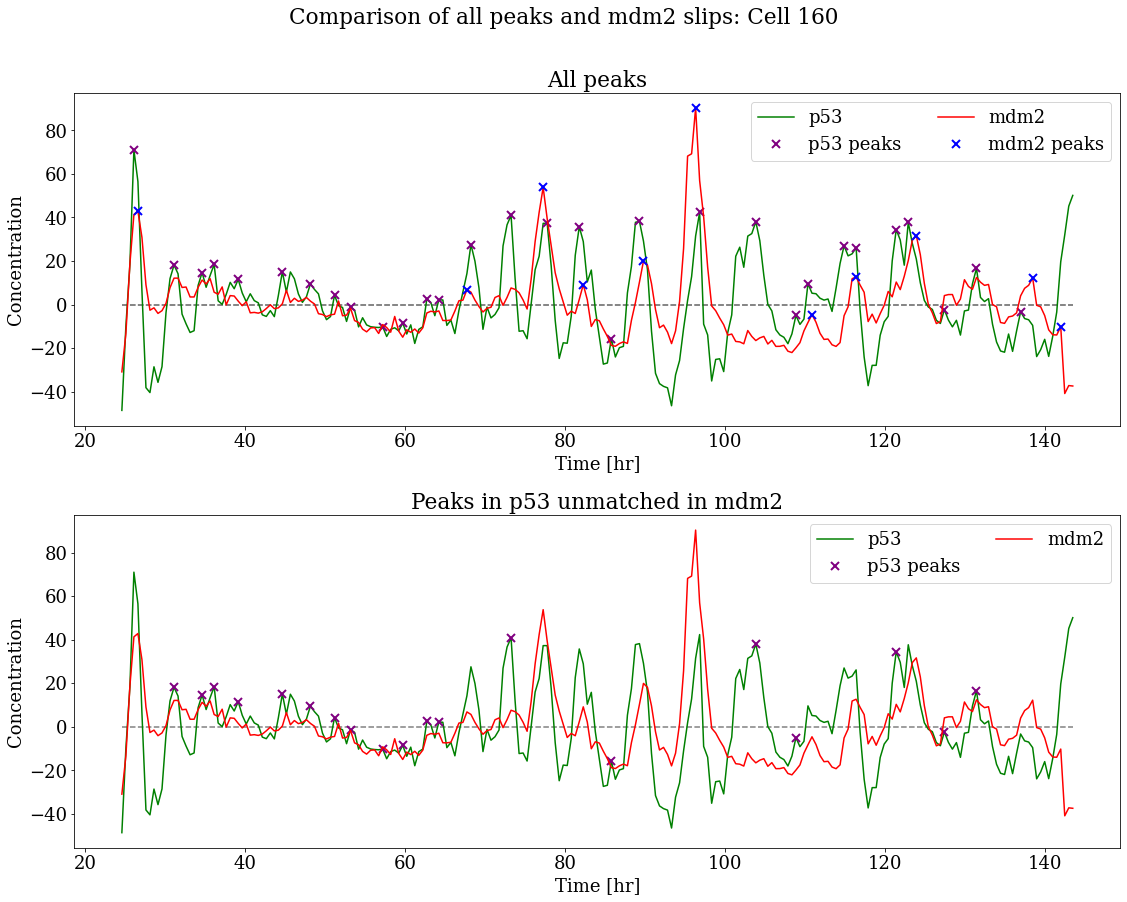

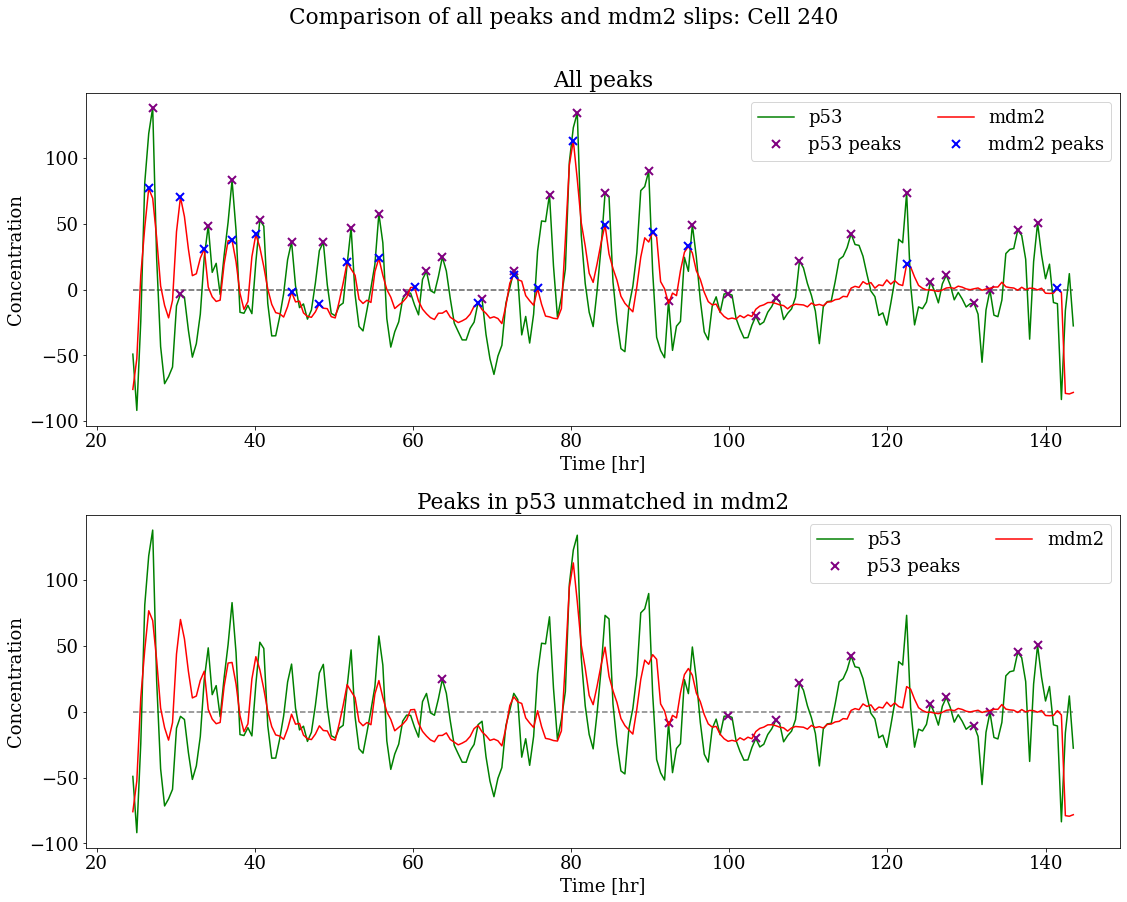

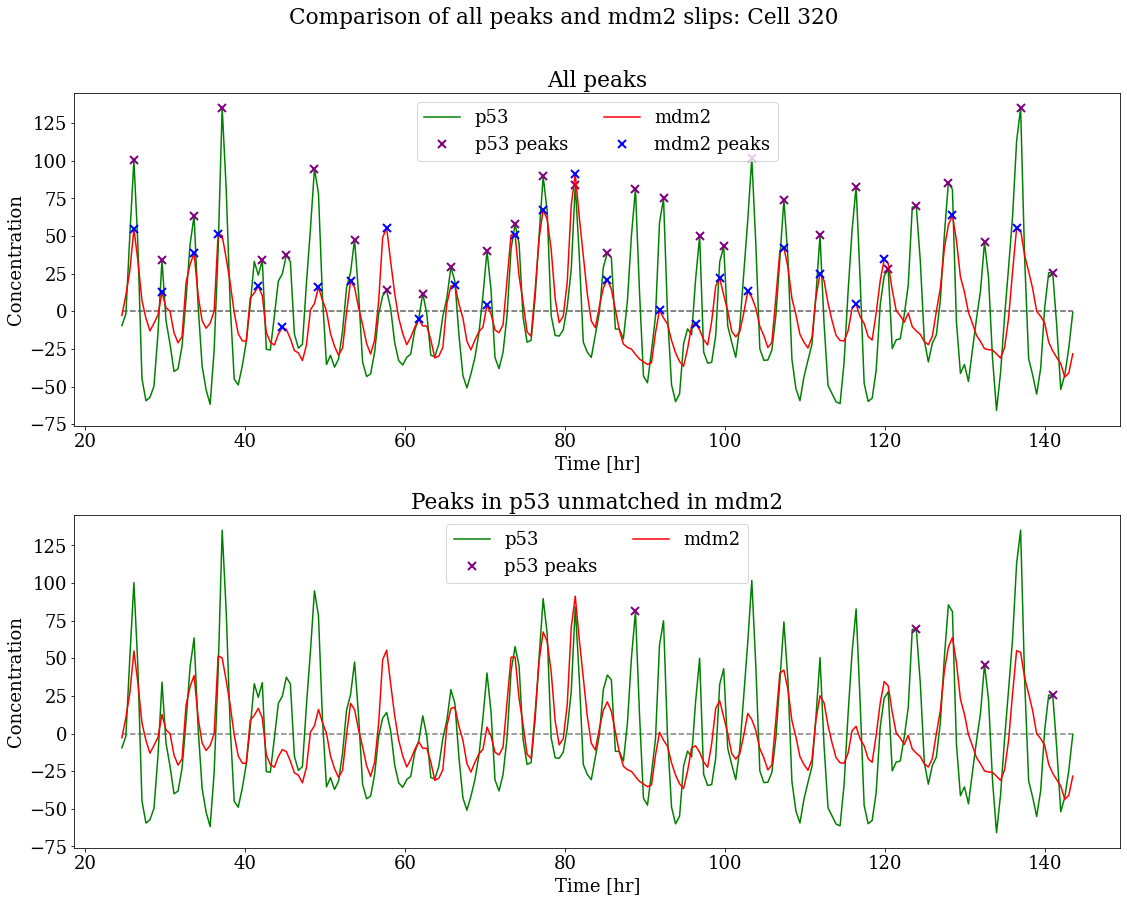

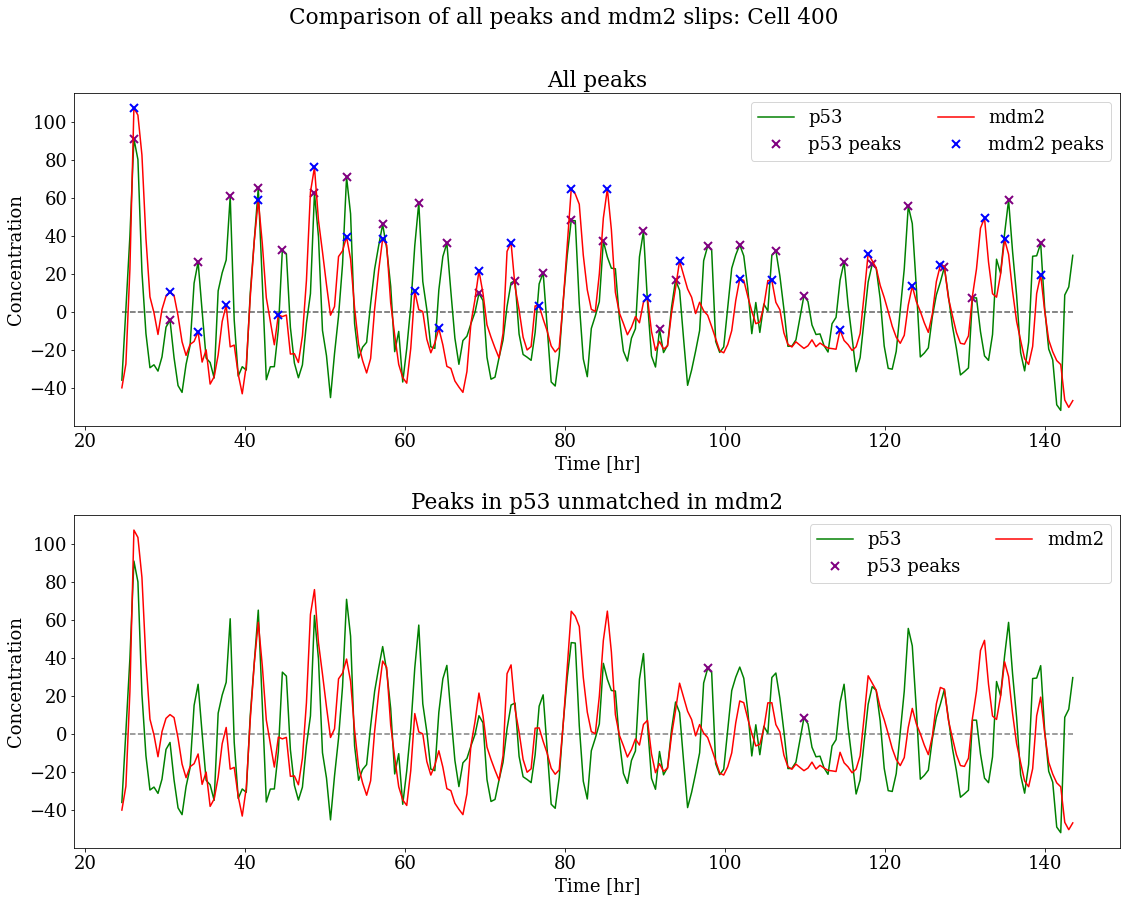

In [41]:
# Finding the unmatched peaks for all cells: 

mdm2_slips = [] 

for i in range(len(resi_p)): 
    
    own_peaks_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)[0]
    own_peaks_m = peak_finder(roll_resi_m[i], N_peaks='low', threshold=avefluct_m)[0]
    
    slips = compare_peaks(own_peaks_p, own_peaks_m, local_min_p[i])[1]
    mdm2_slips.append(slips)
    
    if i % 80 == 0: 
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
        
        fig.suptitle(f'Comparison of all peaks and mdm2 slips: Cell {i}', y=1.05)

        peak_plotter(t, resi_p[i], own_peaks_p, ax1, 'p53')
        peak_plotter(t, roll_resi_m[i], own_peaks_m, ax1, 'mdm2')


        ax1.set(xlabel='Time [hr]', 
               ylabel='Concentration', 
               title='All peaks')
        ax1.legend(ncol=2)
        
        
        peak_plotter(t, resi_p[i], slips, ax2, 'p53')
        ax2.plot(t, roll_resi_m[i], color='red', label='mdm2')


        ax2.set(xlabel='Time [hr]', 
               ylabel='Concentration', 
               title='Peaks in p53 unmatched in mdm2')
        ax2.legend(ncol=2)
        
        fig.tight_layout()   

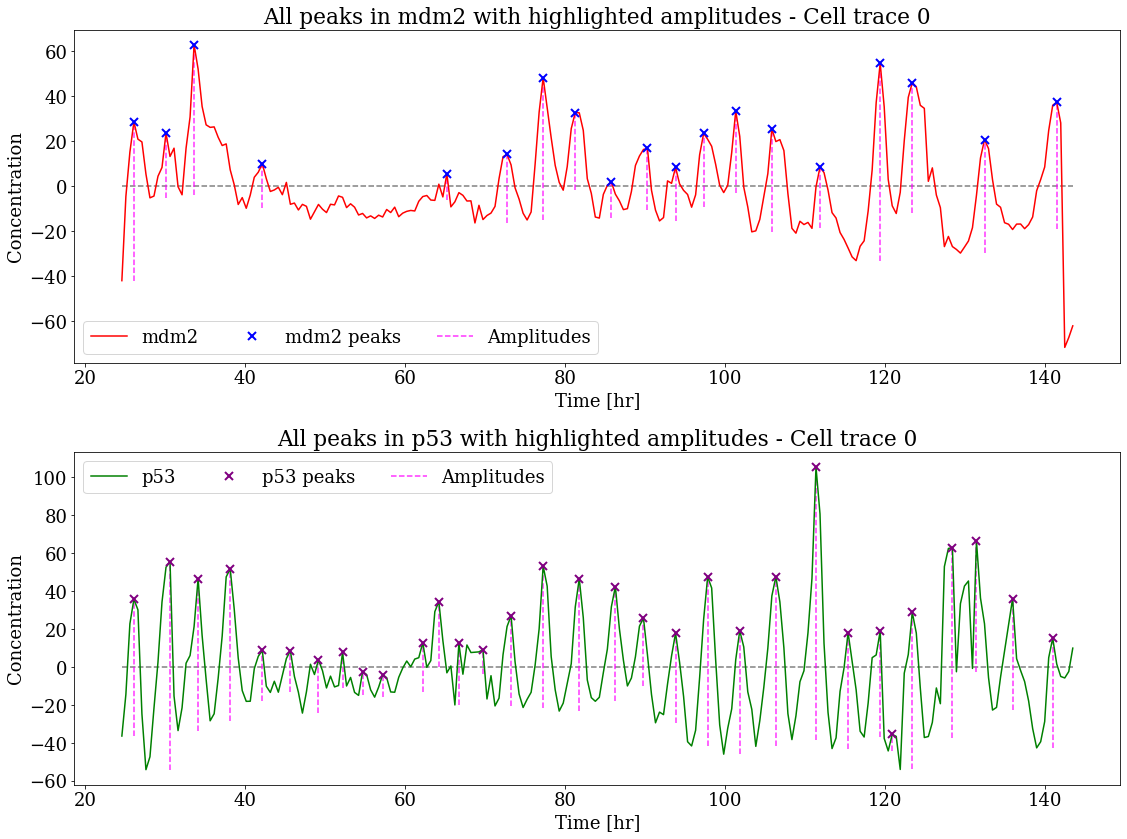

In [42]:
# Finding the amplitudes of the 0'th cell trace and plotting: 

amplitudes_m0 = amplitudes(resi_m0_roll, own_peaks_m0, local_min_m0)
amplitudes_p0 = amplitudes(resi_p0, own_peaks_p0, local_min_p0)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,12))

amp_plotter(t, resi_m0_roll, own_peaks_m0, local_min_m0, 'mdm2', ax1)

ax1.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='All peaks in mdm2 with highlighted amplitudes - Cell trace 0')

ax1.legend(ncol=3)


amp_plotter(t, resi_p0, own_peaks_p0, local_min_p0, 'p53', ax2)

ax2.set(xlabel='Time [hr]', 
       ylabel='Concentration', 
       title='All peaks in p53 with highlighted amplitudes - Cell trace 0')

ax2.legend(ncol=3)

fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/Amplitudes.png');

In [43]:
# Comparing distributions of all amplitudes of p53 and mdm2: 

all_amplitudes_p = []
all_amplitudes_m = []

for i in range(len(resi_p)):
    peaks_p, local_min_p = peak_finder(resi_p[i], N_peaks='high', threshold=avefluct_m)
    peaks_m, local_min_m = peak_finder(resi_m[i], N_peaks='high', threshold=avefluct_m)
    
    all_amplitudes_p.extend(amplitudes(resi_p[i], peaks_p, local_min_p))
    all_amplitudes_m.extend(amplitudes(resi_m[i], peaks_m, local_min_m))

In [44]:
# Fitting the distribution of amplitudes with a gamma-function: 

def gamma_pdf(x, a, loc, scale) :
    """Gamma function"""
    return stats.gamma.pdf(x, a, loc, scale)


Nbins = 100 
xmin_p, xmax_p = np.min(all_amplitudes_p), np.max(all_amplitudes_p) 
xmin_m, xmax_m = np.min(all_amplitudes_m), np.max(all_amplitudes_m)

binwidth_p = (xmax_p - xmin_p) / (Nbins*2) 
binwidth_m = (xmax_m - xmin_m) / Nbins 


def norm_gamma_p(x, N, a, loc, scale):                       
    return N * binwidth_p * gamma_pdf(x, a, loc, scale)


def norm_gamma_m(x, N, a, loc, scale):                       
    return N * binwidth_m * gamma_pdf(x, a, loc, scale)

x_p, y_p, sy_p = zerobin_hist(all_amplitudes_p, Nbins*2, xmin_p, xmax_p, ax)
x_m, y_m, sy_m = zerobin_hist(all_amplitudes_m, Nbins, xmin_m, xmax_m, ax)

minuit_p = chi2_test(all_amplitudes_p, Nbins*2, xmin_p, xmax_p, norm_gamma_p, len(all_amplitudes_p), 90, 10, 1) 
minuit_m = chi2_test(all_amplitudes_m, Nbins, xmin_m, xmax_m, norm_gamma_m, len(all_amplitudes_m), 10, 20, 5) 

In [45]:
# Get the values from the fit: 
print('Fit values for p53:')
chi2_value_p, Ndof_p, p_value_p = get_chi2_values(minuit_p, Nbins*2)

print('\nFit values for mdm2:')

chi2_value_m, Ndof_m, p_value_m = get_chi2_values(minuit_m, Nbins)

Fit values for p53:
Fit value: N = 12249.91605 +/- 109.46765
Fit value: a = 17.97761 +/- 0.64336
Fit value: loc = -114.28590 +/- 5.08383
Fit value: scale = 10.82531 +/- 0.18019
Chi2 value: 266.5   Ndof = 196    Prob(Chi2,Ndof) = 0.001

Fit values for mdm2:
Fit value: N = 14731.55556 +/- 1407.93108
Fit value: a = 2.21119 +/- 0.39454
Fit value: loc = -30.34364 +/- 11.35167
Fit value: scale = 26.50516 +/- 1.78707
Chi2 value: 84.0   Ndof = 96    Prob(Chi2,Ndof) = 0.803


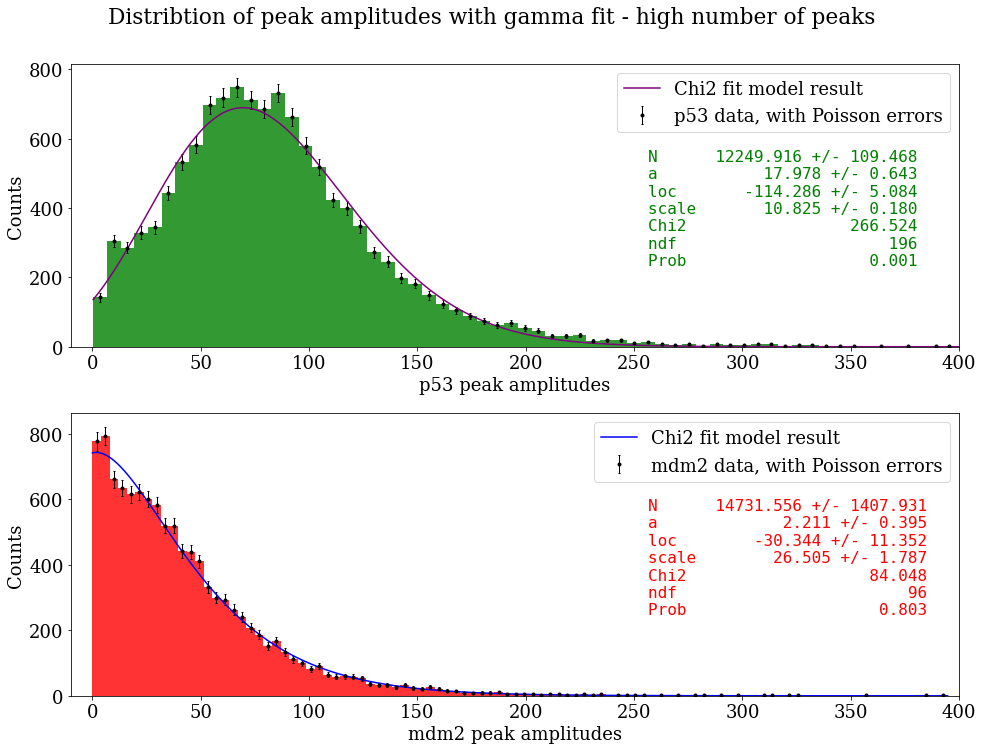

In [46]:
# Plot the data + fit for visualisation: 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))  # figsize is in inches
suptitle1 = fig.suptitle('Distribtion of peak amplitudes with gamma fit - high number of peaks', y=1.05)

ax1.hist(all_amplitudes_p, Nbins*2, range=(xmin_p, xmax_p), color='green', alpha=0.8)
ax1.errorbar(x_p, y_p, yerr=sy_p, label='p53 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax1.set(xlabel = "p53 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400))

xaxis_p = np.linspace(xmin_p, xmax_p, 1000)
ax1.plot(xaxis_p, norm_gamma_p(xaxis_p, *minuit_p.values[:]), 
         linestyle='-', color='purple', label='Chi2 fit model result') 

# Adding fit results to plot:
d_p = {'N':   [minuit_p.values['N'], minuit_p.errors['N']],
     'a':       [minuit_p.values['a'], minuit_p.errors['a']],
     'loc':       [minuit_p.values['loc'], minuit_p.errors['loc']],
     'scale':       [minuit_p.values['scale'], minuit_p.errors['scale']],
     'Chi2':     chi2_value_p,
     'ndf':      Ndof_p,
     'Prob':     p_value_p,
    }

text_p = nice_string_output(d_p, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text_p, ax1, fontsize=16, color='green')
ax1.legend(loc='upper right')

ax2.hist(all_amplitudes_m, Nbins, range=(xmin_m, xmax_m), color='red', alpha=0.8)
ax2.errorbar(x_m, y_m, yerr=sy_m, label='mdm2 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax2.set(xlabel = "mdm2 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400))

xaxis_m = np.linspace(xmin_m, xmax_m, 1000)
ax2.plot(xaxis_m, norm_gamma_m(xaxis_m, *minuit_m.values[:]), 
         linestyle='-', color='b', label='Chi2 fit model result') 

# Adding fit results to plot:
d_m = {'N':   [minuit_m.values['N'], minuit_m.errors['N']],
     'a':       [minuit_m.values['a'], minuit_m.errors['a']],
     'loc':       [minuit_m.values['loc'], minuit_m.errors['loc']],
     'scale':       [minuit_m.values['scale'], minuit_m.errors['scale']],
     'Chi2':     chi2_value_m,
     'ndf':      Ndof_m,
     'Prob':     p_value_m,
    }

text_m = nice_string_output(d_m, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text_m, ax2, fontsize=16, color='red')
ax2.legend(loc='upper right')
fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/AllAmplitudesFit.png', bbox_inches='tight', bbox_extra_artists=[suptitle1]);

In [47]:
# Finding clear the amplitudes in both p53 and mdm2:
lowN_amplitudes_p = []
lowN_amplitudes_m = []

for i in range(len(resi_p)):
    peaks_p, local_min_p = peak_finder(resi_p[i], N_peaks='low', threshold=avefluct_m)
    peaks_m, local_min_m = peak_finder(resi_m[i], N_peaks='low', threshold=avefluct_m)
    
    lowN_amplitudes_p.extend(amplitudes(resi_p[i], peaks_p, local_min_p))
    lowN_amplitudes_m.extend(amplitudes(resi_m[i], peaks_m, local_min_m))

In [48]:
x_p1, y_p1, sy_p1 = zerobin_hist(lowN_amplitudes_p, Nbins*2, xmin_p, xmax_p, ax)
x_m1, y_m1, sy_m1 = zerobin_hist(lowN_amplitudes_m, Nbins, xmin_m, xmax_m, ax)

minuit_p1 = chi2_test(lowN_amplitudes_p, Nbins*2, xmin_p, xmax_p, norm_gamma_p, len(lowN_amplitudes_p), 10, 80, 2) 
minuit_m1 = chi2_test(lowN_amplitudes_m, Nbins, xmin_m, xmax_m, norm_gamma_m, len(lowN_amplitudes_m), 20, 20, 5)
minuit_p1

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 232.1                      │              Nfcn = 410              │
│ EDM = 3.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  11.45e3  │  0.11e3   │            │            │         │         │       │
│ 1 │ a     │   4.06    │   0.14    │            │            │         │         │       │
│ 2 │ loc   │   -4.8    │    1.0    │            │            │         │         │       │
│ 3 │ scale │   22.6    │    0.6    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        N        a      loc    scale │
├───────┼─────────────────────────────────────┤
│     N │ 1.15e+04    0.028   -0.273  -0.0866 │
│     a │    0.028     0.02   -0.133  -0.0797 │
│   loc │   -0.273   -0.133     1.05    0.488 │
│ scale │  -0.0866  -0.0797    0.488    0.339 │
└───────┴─────────────────────────────────────┘

In [49]:
# Get the values from the fit: 
print('Fit values for p53:')
chi2_value_p1, Ndof_p1, p_value_p1 = get_chi2_values(minuit_p1, Nbins*2)

print('\nFit values for mdm2:')

chi2_value_m1, Ndof_m1, p_value_m1 = get_chi2_values(minuit_m1, Nbins)

Fit values for p53:
Fit value: N = 11449.78971 +/- 107.00909
Fit value: a = 4.06376 +/- 0.14148
Fit value: loc = -4.79347 +/- 1.02452
Fit value: scale = 22.56225 +/- 0.58213
Chi2 value: 232.1   Ndof = 196    Prob(Chi2,Ndof) = 0.040

Fit values for mdm2:
Fit value: N = 8839.28161 +/- 90.87734
Fit value: a = 1.59993 +/- 0.02743
Fit value: loc = 5.89111 +/- 0.02496
Fit value: scale = 27.75231 +/- 0.54266
Chi2 value: 113.9   Ndof = 96    Prob(Chi2,Ndof) = 0.102


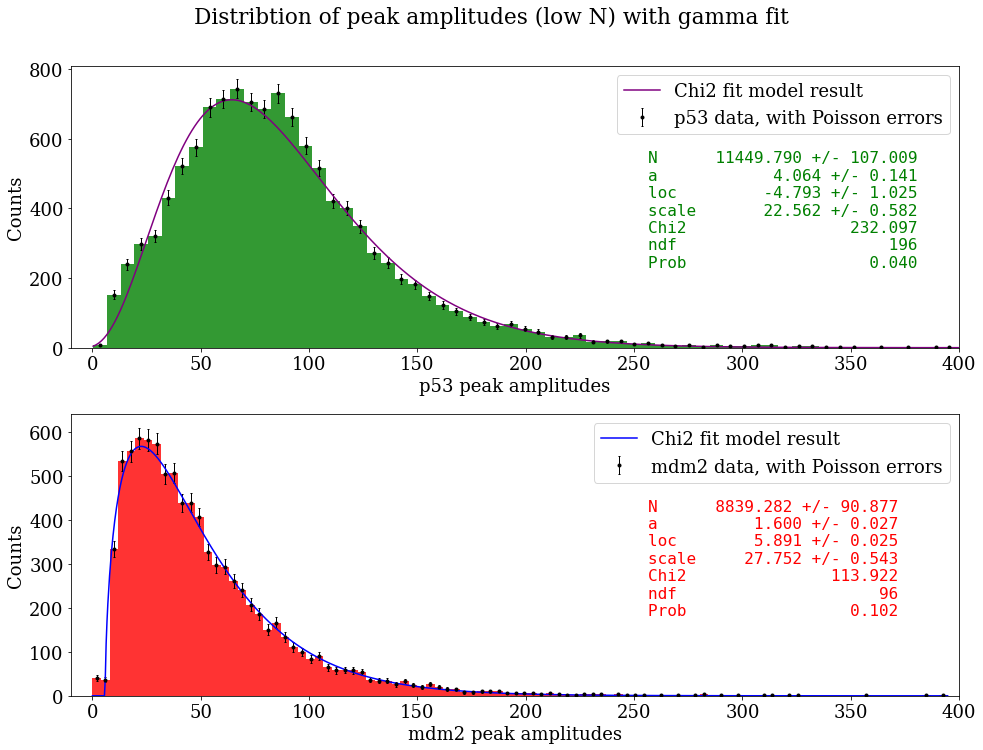

In [50]:
# Plot the data + fit for visualisation: 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))  # figsize is in inches
suptitle2 = fig.suptitle('Distribtion of peak amplitudes (low N) with gamma fit', y=1.05)

ax1.hist(lowN_amplitudes_p, Nbins*2, range=(xmin_p, xmax_p), color='green', alpha=0.8)
ax1.errorbar(x_p1, y_p1, yerr=sy_p1, label='p53 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax1.set(xlabel = "p53 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400))

xaxis_p = np.linspace(xmin_p, xmax_p, 1000)
ax1.plot(xaxis_p, norm_gamma_p(xaxis_p, *minuit_p1.values[:]), 
         linestyle='-', color='purple', label='Chi2 fit model result') 

# Adding fit results to plot:
d_p1 = {'N':   [minuit_p1.values['N'], minuit_p1.errors['N']],
     'a':       [minuit_p1.values['a'], minuit_p1.errors['a']],
     'loc':       [minuit_p1.values['loc'], minuit_p1.errors['loc']],
     'scale':       [minuit_p1.values['scale'], minuit_p1.errors['scale']],
     'Chi2':     chi2_value_p1,
     'ndf':      Ndof_p1,
     'Prob':     p_value_p1,
    }

text_p1 = nice_string_output(d_p1, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text_p1, ax1, fontsize=16, color='green')
ax1.legend(loc='upper right')

ax2.hist(lowN_amplitudes_m, Nbins, range=(xmin_m, xmax_m), color='red', alpha=0.8)
ax2.errorbar(x_m1, y_m1, yerr=sy_m1, label='mdm2 data, with Poisson errors', 
             fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax2.set(xlabel = "mdm2 peak amplitudes",
       ylabel = "Counts",
       xlim = (-10, 400))

xaxis_m = np.linspace(xmin_m, xmax_m, 1000)
ax2.plot(xaxis_m, norm_gamma_m(xaxis_m, *minuit_m1.values[:]), 
         linestyle='-', color='b', label='Chi2 fit model result') 

# Adding fit results to plot:
d_m1 = {'N':   [minuit_m1.values['N'], minuit_m1.errors['N']],
     'a':       [minuit_m1.values['a'], minuit_m1.errors['a']],
     'loc':       [minuit_m1.values['loc'], minuit_m1.errors['loc']],
     'scale':       [minuit_m1.values['scale'], minuit_m1.errors['scale']],
     'Chi2':     chi2_value_m1,
     'ndf':      Ndof_m1,
     'Prob':     p_value_m1,
    }

text_m1 = nice_string_output(d_m1, extra_spacing=2, decimals=3)
add_text_to_ax(0.65, 0.7, text_m1, ax2, fontsize=16, color='red')
ax2.legend(loc='upper right')
fig.tight_layout()

if save_plots: 
    fig.savefig(r'Graphs/LowNAmplitudesFit.png', bbox_inches='tight', bbox_extra_artists=[suptitle1]);